In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('timeseries.csv')


In [4]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)
# df['time'][78886]

96418                                        20201231:1007
96419                                        20201231:1107
96420                                        20201231:1207
96421                                        20201231:1307
96422                                        20201231:1407
96423                                        20201231:1507
96424                                        20201231:1607
96425                                        20201231:1707
96426                                        20201231:1807
96427                                        20201231:1907
96428                                        20201231:2007
96429                                        20201231:2107
96430                                        20201231:2207
96431                                        20201231:2307
96433    G(i): Global irradiance on the inclined plane ...
96434                           H_sun: Sun height (degree)
96435            T2m: 2-m air temperature (degree Celsiu

In [5]:
df = df[:96431:]
df_multi = df.iloc[:,2:5] # removing the time column 
df.tail(30)
print(df_multi.tail(10))
print(df_multi.dtypes)
# y = [x for x in df['Int'] if x == 0.0]
# print(y)b
# type(df_multi)


       H_sun    T2m  WS10m
96421   24.3  28.01   3.72
96422   11.9  26.94   3.59
96423    0.0  24.97   2.55
96424    0.0  23.19   1.86
96425    0.0  20.98   1.45
96426    0.0  19.31   1.38
96427    0.0  17.90   1.45
96428    0.0  16.52   1.52
96429    0.0  15.39   1.59
96430    0.0  14.28   1.59
H_sun    float64
T2m      float64
WS10m    float64
dtype: object


In [8]:
# Initialize the Min-Max Scaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)
print(scaled_data.shape)
print(scaled_data[1:10,:])

(96431, 3)
[[0.         0.15526224 0.26194399]
 [0.         0.13581105 0.29489292]
 [0.         0.12782216 0.30642504]
 [0.03197405 0.12400139 0.31795717]
 [0.18153383 0.18339701 0.28336079]
 [0.32228916 0.32025009 0.28336079]
 [0.44775255 0.44911428 0.28336079]
 [0.54622335 0.51684613 0.27347611]
 [0.59905005 0.55331712 0.20428336]]


In [9]:
df_orignal_scaled = scaled_data
df_orignal = df_multi
df_scaled = scaled_data[:78888:]

In [10]:

print(df_scaled[0:5,:]) # this it the input
print(df_scaled[5,:]) # this is the output

[[0.         0.17262939 0.26194399]
 [0.         0.15526224 0.26194399]
 [0.         0.13581105 0.29489292]
 [0.         0.12782216 0.30642504]
 [0.03197405 0.12400139 0.31795717]]
[0.18153383 0.18339701 0.28336079]


In [11]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,:]
    y.append(label)
  return np.array(X), np.array(y)

In [12]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[1])
print("slfejlksdjlfkjdslkjfjlk")
print(y1[1])
X1.shape, y1.shape

[[0.         0.15526224 0.26194399]
 [0.         0.13581105 0.29489292]
 [0.         0.12782216 0.30642504]
 [0.03197405 0.12400139 0.31795717]
 [0.18153383 0.18339701 0.28336079]]
slfejlksdjlfkjdslkjfjlk
[0.32228916 0.32025009 0.28336079]


((78883, 5, 3), (78883, 3))

In [13]:
X_train1, y_train1 = X1[:61367], y1[:61367]
X_val1, y_val1 = X1[61367:70127], y1[61367:70127] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[70128:], y1[70128:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape


((61367, 5, 3), (61367, 3), (8760, 5, 3), (8760, 3), (8755, 5, 3), (8755, 3))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 3)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(3, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 17,955
Trainable params: 17,955
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=6, verbose=1, mode='min')

In [19]:
cp1 = ModelCheckpoint('model_correlation/', save_best_only=True)
# metrics , learning rate, loss  can be changed 
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,early_stopping])

Epoch 1/100
1913/1918 [============================>.] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0869

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 18s 8ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0524
Epoch 2/100
1907/1918 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0468

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 16s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 3/100
1913/1918 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0440

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 16s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 4/100
1917/1918 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 16s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 5/100
1910/1918 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0410

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 17s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 6/100
1918/1918 [==============================] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0398

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 17s 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 7/100
1918/1918 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0389

INFO:tensorflow:Assets written to: model_correlation\assets


INFO:tensorflow:Assets written to: model_correlation\assets


1918/1918 [==============================] - 18s 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 7: early stopping


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model_correlation/')

In [22]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1.flatten()})
train_results.head(30)

1918/1918 [==============================] - 4s 2ms/step


,Train Predictions,Actuals
0,0.133397,0.181534
1,0.185051,0.183397
2,0.279414,0.283361
3,0.361901,0.322289
4,0.351845,0.320250
5,0.233927,0.283361
6,0.469905,0.447753
7,0.430605,0.449114
8,0.280709,0.283361
9,0.557098,0.546223


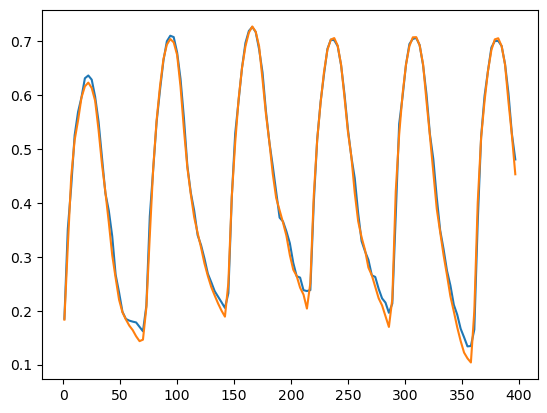

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][1:400:3])
plt.plot(train_results['Actuals'][1:400:3])

In [29]:

val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results

274/274 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,0.051349,0.031974
1,0.147935,0.113234
2,0.437441,0.489292
3,0.117947,0.181534
4,0.183925,0.191386
...,...,...
26275,0.180246,0.150747
26276,0.285394,0.294893
26277,0.059204,0.000000
26278,0.168128,0.129559


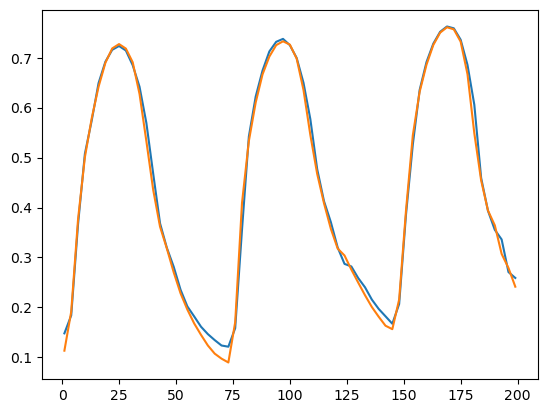

In [30]:
plt.plot(val_results['Val Predictions'][1:200:3])
plt.plot(val_results['Actuals'][1:200:3])

In [31]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

274/274 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,0.129237,0.181534
1,0.174137,0.213963
2,0.233124,0.181219
3,0.351367,0.322289
4,0.381907,0.435568
...,...,...
26260,0.321500,0.308093
26261,0.382365,0.375618
26262,0.012810,0.000000
26263,0.283247,0.278569


In [33]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=1, end=400):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end:3])
  plt.plot(df['Actuals'][start:end:3])
  return df, mse(predictions, y)

274/274 [==============================] - 0s 2ms/step


(       Predictions   Actuals
 0         0.129237  0.181534
 1         0.174137  0.213963
 2         0.233124  0.181219
 3         0.351367  0.322289
 4         0.381907  0.435568
 ...            ...       ...
 26260     0.321500  0.308093
 26261     0.382365  0.375618
 26262     0.012810  0.000000
 26263     0.283247  0.278569
 26264     0.388759  0.385502
 
 [26265 rows x 2 columns],
 0.0012666674492636362)

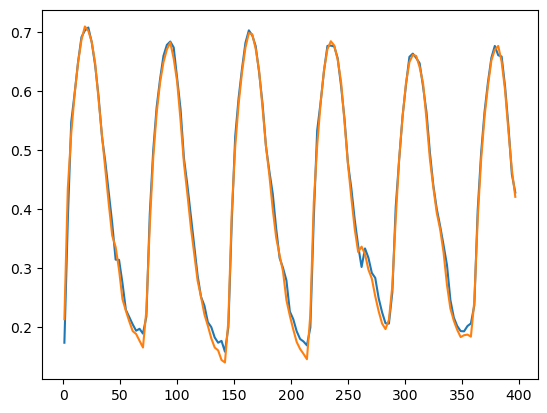

In [34]:
plot_predictions1(model1, X_test1, y_test1.flatten())

In [35]:
kkk = df_orignal_scaled[78888:78893,:]
print(type(kkk))
print(kkk.shape)
reshaped_array = np.reshape(kkk, (1, 5, 3))
print(reshaped_array)
predictions = model1.predict(reshaped_array)
print(predictions)
 
original= scaler.inverse_transform(predictions)
print(original)
# predictions
# inverse_data = np.zeros((len(predictions), scaler.shape[1]))

<class 'numpy.ndarray'>
(5, 3)
[[[0.         0.25946509 0.3970346 ]
  [0.         0.24175061 0.3970346 ]
  [0.         0.22681487 0.3970346 ]
  [0.         0.21048975 0.40856672]
  [0.03197405 0.19590135 0.40856672]]]
1/1 [==============================] - 0s 33ms/step
[[0.10878997 0.24005796 0.41485357]]
[[ 9.39075   13.111269   2.5181613]]


In [36]:

input = df_orignal_scaled[78888:78893,:]  # Initial input extracted from your original scaled DataFrame
output_scaled = []  
output_not_scaled = [] 

for i in range(24):
    # Reshape input for the model prediction
    reshaped_array = np.reshape(input, (1, 5, 3))
    scaled_prediction = model1.predict(reshaped_array)
    
    # Reshape the prediction to match the input shape if necessary
    # This example assumes the model returns a prediction with shape (1, 4)
    # Adjust the reshaping based on the actual shape of your model's output
    scaled_prediction_reshaped = np.reshape(scaled_prediction, (1, 3))
    input = np.reshape(input, (5, 3))  # Ensure input is in the correct shape before appending
    # Append the new prediction at the end of the input array
    input = np.vstack([input, scaled_prediction_reshaped])  # Stack vertically to add as a new row
    
    # Remove the oldest entry to maintain the sliding window of input data
    input = input[1:, :]  # Keep the last 5 entries, including the newly added prediction
 
    output_scaled.append(scaled_prediction)


# print(output_scaled)  # Remains empty, uncomment if needed
print(output_scaled)  # Print or process the predictions as 




1/1 [==============================] - 0s 22ms/step
[array([[0.10878997, 0.24005796, 0.41485357]], dtype=float32), array([[0.22301063, 0.3378895 , 0.43618238]], dtype=float32), array([[0.35996696, 0.46799207, 0.4727    ]], dtype=float32), array([[0.4855597 , 0.5852919 , 0.48599875]], dtype=float32), array([[0.5848204 , 0.6764693 , 0.41135803]], dtype=float32), array([[0.64249855, 0.74619144, 0.27295932]], dtype=float32), array([[0.63324314, 0.79089624, 0.17522739]], dtype=float32), array([[0.5518181 , 0.8161825 , 0.16149372]], dtype=float32), array([[0.4343096 , 0.82910496, 0.19500397]], dtype=float32), array([[0.30732015, 0.82271284, 0.2465319 ]], dtype=float32), array([[0.17208377, 0.7911341 , 0.29832152]], dtype=float32), array([[0.04764709, 0.7352503 , 0.31446642]], dtype=float32), array([[0.02257796, 0.66944844, 0.32437956]], dtype=float32), array([[0.01275713, 0.60559016, 0.3370408 ]], dtype=float32), array([[0.00436813, 0.5519498 , 0.34038904]], dtype=float32), array([[-0.002283

In [37]:
print("this is the real scaled output")
for i in output_scaled:
    original= scaler.inverse_transform(i)
    print(original)

this is the real scaled output
[[ 9.39075   13.111269   2.5181613]]
[[19.250278 15.927838  2.647627]]
[[31.072348 19.67349   2.869289]]
[[41.913513  23.050554   2.9500124]]
[[50.481697  25.67555    2.4969432]]
[[55.460476  27.682852   1.6568631]]
[[54.66155   28.969904   1.0636302]]
[[47.632935   29.697893    0.98026687]]
[[37.489605  30.069933   1.1836741]]
[[26.527876  29.885904   1.4964486]]
[[14.854271  28.976751   1.8108116]]
[[ 4.112897  27.367855   1.9088111]]
[[ 1.9489292 25.47342    1.968984 ]]
[[ 1.1011955 23.634941   2.0458376]]
[[ 0.3770573 22.090633   2.0661614]]
[[-0.1971444 20.899868   2.0236874]]
[[-0.6974121 19.882427   1.951989 ]]
[[-1.0198442 18.932323   1.8945484]]
[[-1.0347391 18.065987   1.8699737]]
[[-0.13689174 17.384045    1.8725678 ]]
[[ 2.3079357 17.13475    1.8937453]]
[[ 6.681028  17.53703    1.9511062]]
[[12.992724 18.669128  2.064732]]
[[20.690287 20.391165  2.216765]]
